<a href="https://colab.research.google.com/github/Davidavid45/Cost-Optimization-for-Computer-Chip/blob/main/Cost_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing Necessary Libraries

In [1]:

!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install coinor-cbc


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-cbc is already the newest version (2.10.7+ds1-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Linear Programming Solution

In [3]:
production_cost = pd.read_excel('SuperChipData.xlsx', sheet_name='Production Costs')
prod_capacity = pd.read_excel('SuperChipData.xlsx', sheet_name='Production Capacity')
shipping_cost = pd.read_excel('SuperChipData.xlsx', sheet_name='Shipping Costs')
Demand = pd.read_excel('SuperChipData.xlsx', sheet_name='Sales Region Demand')

In [4]:
Demand.head()

,Sales Region,Computer Chip,Yearly Demand (thousands)
0,1,1,1.18
1,1,2,2.17
2,1,3,2.82
3,1,4,0.87
4,1,5,2.63


In [5]:
prod_capacity['Computer Chip Production Capacity (thousands per year)'] = prod_capacity['Computer Chip Production Capacity (thousands per year)'] * 1000
Demand['Yearly Demand (thousands)'] = Demand['Yearly Demand (thousands)'] * 1000
Demand.head()

,Sales Region,Computer Chip,Yearly Demand (thousands)
0,1,1,1180.0
1,1,2,2170.0
2,1,3,2820.0
3,1,4,870.0
4,1,5,2630.0


## Defining the Optimization Problem:
- Decision Variables:
	- How many of each chip to produce at each facility.
	- How many chips to ship from each facility to each sales region.
- Objective Function:
	- Minimize the total cost (production cost + shipping cost).
- Constraints:
	- Production limits at each facility.
	- Demand satisfaction for each chip in all regions.

### Initializing Model

In [6]:
model = ConcreteModel()

model.facilities = Set(initialize=production_cost['Facility'].unique())
model.chips = Set(initialize=production_cost['Computer Chip'].unique())
model.regions = Set(initialize=shipping_cost['Sales Region'].unique())

model.prod_cost = Param(model.facilities, model.chips,
                        initialize=production_cost.set_index(['Facility', 'Computer Chip'])['Production Cost ($ per chip)'].to_dict())

model.shipping_cost = Param(model.facilities, model.chips, model.regions,
                            initialize=shipping_cost.set_index(['Facility', 'Computer Chip', 'Sales Region'])['Shipping Cost ($ per chip)'].to_dict())
model.prod_capacity = Param(model.facilities,
                            initialize=prod_capacity.set_index('Facility')['Computer Chip Production Capacity (thousands per year)'].to_dict())
model.demand = Param(model.chips, model.regions,
                     initialize=Demand.set_index(['Computer Chip', 'Sales Region'])['Yearly Demand (thousands)'].to_dict())

### Decision Variables

In [7]:
model.production = Var(model.facilities, model.chips, domain=NonNegativeReals)
model.shipping = Var(model.facilities, model.chips, model.regions, domain=NonNegativeReals)

### Objective Function

In [8]:
def total_cost_rule(model):
    production_cost = sum(model.prod_cost[f, c] * model.production[f, c] for f in model.facilities for c in model.chips)
    shipping_cost = sum(model.shipping_cost[f, c, r] * model.shipping[f, c, r] for f in model.facilities for c in model.chips for r in model.regions)
    return production_cost + shipping_cost

model.obj = Objective(rule=total_cost_rule, sense=minimize)

### Constraints
1. Production Capacity Constraint
$$
\sum_{\text{chip}} \text{Production at facility} \leq \text{Facility capacity}
$$

2.	Demand Satisfaction Constraint
$$
\sum_{\text{facility}} \text{Shipping to region} \geq \text{Demand}
$$

3.	Flow Balance Constraint
$$
\sum_{\text{region}} \text{Shipping from facility} \leq \text{Production at facility}
$$




In [9]:
# Production capacity constraint
def production_capacity_rule(model, f):
    return sum(model.production[f, c] for c in model.chips) <= model.prod_capacity[f]
model.production_capacity = Constraint(model.facilities, rule=production_capacity_rule)


# Demand satisfaction constraint
def demand_satisfaction_rule(model, r, c):
    return sum(model.shipping[f, c, r] for f in model.facilities) >= model.demand[c, r]
model.demand_satisfaction = Constraint(model.regions, model.chips, rule=demand_satisfaction_rule)


# Flow balance constraint
def flow_balance_rule(model, f, c):
    return sum(model.shipping[f, c, r] for r in model.regions) <= model.production[f, c]
model.flow_balance = Constraint(model.facilities, model.chips, rule=flow_balance_rule)

### CBC Solver

In [10]:
solver = SolverFactory('cbc')

result = solver.solve(model, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpdtc6udq3.pyomo.lp -stat=1 -solve -solu /tmp/tmpdtc6udq3.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 844 (-1) rows, 3595 (-5) columns and 7190 (-10) elements
Statistics for presolved model


Problem has 844 rows, 3595 columns (3595 with objective) and 7190 elements
Column breakdown:
3595 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
689 of type G other, 150 of type L 0.0, 0 of type L 1.0, 
5 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 844 (-1) rows, 3595 (-5) columns and 7190 (-10) elements
Perturbing problem b

In [11]:
print(f"Solver Status: {result.solver.status}")
print(f"Solver Termination Condition: {result.solver.termination_condition}")

Solver Status: ok
Solver Termination Condition: optimal


### Results

#### Production Results

In [12]:
production_results = []
for f in model.facilities:
    for c in model.chips:
        if model.production[f, c].value > 0:
            production_results.append({
                "Facility": f,
                "Chip": c,
                "Produced": model.production[f, c].value
            })

production_df = pd.DataFrame(production_results)
production_df.head()

,Facility,Chip,Produced
0,Alexandria,6,24620.0
1,Alexandria,8,30640.0
2,Alexandria,9,35210.0
3,Alexandria,11,33270.0
4,Alexandria,12,31360.0


#### Shipping Results

In [13]:
shipping_results = []
for f in model.facilities:
    for c in model.chips:
        for r in model.regions:
            if model.shipping[f, c, r].value > 0:
                shipping_results.append({
                    "Facility": f,
                    "Chip": c,
                    "Region": r,
                    "Shipped": model.shipping[f, c, r].value
                })

shipping_df = pd.DataFrame(shipping_results)
shipping_df.head()

,Facility,Chip,Region,Shipped
0,Alexandria,6,1,460.0
1,Alexandria,6,2,2940.0
2,Alexandria,6,3,890.0
3,Alexandria,6,5,1590.0
4,Alexandria,6,6,1310.0


In [14]:
# Compute production cost
prod_costs = []
for f in model.facilities:
    for c in model.chips:
        cost = model.prod_cost[f, c] * model.production[f, c].value
        prod_costs.append({"Facility": f, "Chip": c, "Production Cost": cost})

prod_cost_df = pd.DataFrame(prod_costs)
total_production_cost = prod_cost_df["Production Cost"].sum()
prod_cost_df.head()
print(f"Total Production Cost: ${total_production_cost:.2f}")

Total Production Cost: $47309680.40


In [15]:
# Compute shipping cost
ship_costs = []
for f in model.facilities:
    for c in model.chips:
        for r in model.regions:
            cost = model.shipping_cost[f, c, r] * model.shipping[f, c, r].value
            ship_costs.append({"Facility": f, "Chip": c, "Region": r, "Shipping Cost": cost})

ship_cost_df = pd.DataFrame(ship_costs)
total_shipping_cost = ship_cost_df["Shipping Cost"].sum()
ship_cost_df.head()
print(f"Total Shipping Cost: ${total_shipping_cost:.2f}")

Total Shipping Cost: $1773750.00


#### Combined Results

In [16]:
# Total cost summary
total_cost = total_production_cost + total_shipping_cost
cost_summary_df = pd.DataFrame({
    "Cost Component": ["Production", "Shipping", "Total"],
    "Cost ($)": [total_production_cost, total_shipping_cost, total_cost]
})

print(cost_summary_df)

  Cost Component    Cost ($)
0     Production  47309680.4
1       Shipping   1773750.0
2          Total  49083430.4


# Current Policy

## Checking the Proportional Production Policy

### Calculate Proportional Share of Capacity

Each facility’s proportional share is calculated based on its production capacity relative to the total capacity:
$$
\text{Proportional Share for Facility \( f \)} = \frac{\text{Capacity of Facility \( f \)}}{\text{Total Capacity}}
$$


In [17]:
total_capacity = prod_capacity['Computer Chip Production Capacity (thousands per year)'].sum()

prod_capacity['Proportional Share'] = prod_capacity['Computer Chip Production Capacity (thousands per year)'] / total_capacity

In [18]:
# Merge demand data with proportional shares
proportional_df = Demand.copy()
proportional_df = proportional_df.merge(
    prod_capacity[['Facility', 'Proportional Share']],
    how='cross'
)

# Calculate proportional production
proportional_df['Produced'] = proportional_df['Yearly Demand (thousands)'] * proportional_df['Proportional Share']

In [19]:
proportional_df.head()

,Sales Region,Computer Chip,Yearly Demand (thousands),Facility,Proportional Share,Produced
0,1,1,1180.0,Alexandria,0.253275,298.864629
1,1,1,1180.0,Richmond,0.227074,267.947598
2,1,1,1180.0,Norfolk,0.213974,252.489083
3,1,1,1180.0,Roanoke,0.157205,185.502183
4,1,1,1180.0,Charolottesville,0.148472,175.196507


### Compute Costs for Proportional Policy

In [20]:
# Merge with production costs
proportional_df = proportional_df.merge(
    production_cost,
    on=['Facility', 'Computer Chip'],
    how='left'
)

# Calculate production costs
proportional_df['Production_Cost'] = proportional_df['Produced'] * proportional_df['Production Cost ($ per chip)']


In [21]:
# Merge with shipping costs
proportional_df = proportional_df.merge(
    shipping_cost,
    on=['Facility', 'Computer Chip', 'Sales Region'],
    how='left'
)

# Calculate shipping costs
proportional_df['Shipping_Cost'] = proportional_df['Produced'] * proportional_df['Shipping Cost ($ per chip)']

In [22]:
proportional_df.head()

,Sales Region,Computer Chip,Yearly Demand (thousands),Facility,Proportional Share,Produced,Production Cost ($ per chip),Production_Cost,Shipping Cost ($ per chip),Shipping_Cost
0,1,1,1180.0,Alexandria,0.253275,298.864629,59.79,17869.116157,1.76,526.001747
1,1,1,1180.0,Richmond,0.227074,267.947598,46.73,12521.191266,2.11,565.369432
2,1,1,1180.0,Norfolk,0.213974,252.489083,54.71,13813.677729,2.39,603.448908
3,1,1,1180.0,Roanoke,0.157205,185.502183,44.74,8299.367686,2.26,419.234934
4,1,1,1180.0,Charolottesville,0.148472,175.196507,45.35,7945.161572,2.31,404.703930


In [23]:
total_production_prop_cost = proportional_df["Production_Cost"].sum()
total_shipping_prop_cost = proportional_df["Shipping_Cost"].sum()
total_prop_cost = total_production_prop_cost + total_shipping_prop_cost

# Print results
print(f"Proportional Production Policy Costs:")
print(f"  Total Production Cost: ${total_production_prop_cost:.2f}")
print(f"  Total Shipping Cost: ${total_shipping_prop_cost:.2f}")
print(f"  Total Cost: ${total_prop_cost:.2f}")

Proportional Production Policy Costs:
  Total Production Cost: $54246470.75
  Total Shipping Cost: $1887389.21
  Total Cost: $56133859.96


### Compare to Optimized Results

In [24]:
comparison_data = {
    'Cost Component': ['Production Cost', 'Shipping Cost', 'Total Cost'],
    'Optimized Policy': [total_production_cost, total_shipping_cost, total_cost],
    'Proportional Policy': [total_production_prop_cost, total_shipping_prop_cost, total_prop_cost]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Cost Component,Optimized Policy,Proportional Policy
0,Production Cost,47309680.4,5.424647e+07
1,Shipping Cost,1773750.0,1.887389e+06
2,Total Cost,49083430.4,5.613386e+07


## Capacity Expansion at One Facility
Evaluating which facility should receive additional production capacity to minimize overall costs.

In [25]:
# Increasing capacity by 10% for each facility
capacity_expansion_results = []
for f in prod_capacity['Facility']:
    expanded_capacity = prod_capacity.copy()

    # Increase capacity of the specific facility by 10%
    expanded_capacity.loc[expanded_capacity['Facility'] == f, 'Computer Chip Production Capacity (thousands per year)'] *= 1.1

    # Recalculate proportional shares
    total_capacity = expanded_capacity['Computer Chip Production Capacity (thousands per year)'].sum()
    expanded_capacity['Proportional Share'] = expanded_capacity['Computer Chip Production Capacity (thousands per year)'] / total_capacity

    # Recalculate proportional production
    expanded_production_df = Demand.copy()
    expanded_production_df = expanded_production_df.merge(
        expanded_capacity[['Facility', 'Proportional Share']],
        how='cross'
    )
    expanded_production_df['Produced'] = expanded_production_df['Yearly Demand (thousands)'] * expanded_production_df['Proportional Share'] * 1000

    # Recalculate costs
    expanded_production_df = expanded_production_df.merge(production_cost, on=['Facility', 'Computer Chip'], how='left')
    expanded_production_df['Production Cost'] = expanded_production_df['Produced'] * expanded_production_df['Production Cost ($ per chip)']
    expanded_production_df = expanded_production_df.merge(shipping_cost, on=['Facility', 'Computer Chip', 'Sales Region'], how='left')
    expanded_production_df['Shipping Cost'] = expanded_production_df['Produced'] * expanded_production_df['Shipping Cost ($ per chip)']

    # Compute total costs
    total_production_cost = expanded_production_df['Production Cost'].sum()
    total_shipping_cost = expanded_production_df['Shipping Cost'].sum()
    total_cost = total_production_cost + total_shipping_cost

    # Append results
    capacity_expansion_results.append({
        "Facility": f,
        "Total Production Cost": total_production_cost,
        "Total Shipping Cost": total_shipping_cost,
        "Total Cost": total_cost
    })

<ipython-input-25-dab4a074454c>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[382800.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  expanded_capacity.loc[expanded_capacity['Facility'] == f, 'Computer Chip Production Capacity (thousands per year)'] *= 1.1
<ipython-input-25-dab4a074454c>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[237600.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  expanded_capacity.loc[expanded_capacity['Facility'] == f, 'Computer Chip Production Capacity (thousands per year)'] *= 1.1
<ipython-input-25-dab4a074454c>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[224400.]' has dtype incompatible with int64, please explicitl

### Results

In [26]:
capacity_expansion_df = pd.DataFrame(capacity_expansion_results)
capacity_expansion_df = capacity_expansion_df.sort_values(by="Total Cost")

capacity_expansion_df

,Facility,Total Production Cost,Total Shipping Cost,Total Cost
1,Richmond,5.419466e+10,1.884274e+09,5.607893e+10
0,Alexandria,5.421563e+10,1.879044e+09,5.609468e+10
2,Norfolk,5.422275e+10,1.889295e+09,5.611204e+10
3,Roanoke,5.427675e+10,1.891328e+09,5.616808e+10
4,Charolottesville,5.432341e+10,1.893099e+09,5.621651e+10


### Observations
1.	The Richmond facility leads to the lowest total cost after capacity expansion, making it the best candidate for a capacity increase.
2.	Total costs decrease incrementally, depending on the facility receiving additional capacity.

##  Demand Increase Analysis

Evaluating how a 10% increase in demand affects costs and whether the current production and shipping capacities are sufficient.

In [27]:
# Increase demand by 10%
demand_increase_df = Demand.copy()
demand_increase_df['Yearly Demand (thousands)'] *= 1.1

In [28]:
demand_increase_df.head()

,Sales Region,Computer Chip,Yearly Demand (thousands)
0,1,1,1298.0
1,1,2,2387.0
2,1,3,3102.0
3,1,4,957.0
4,1,5,2893.0


In [29]:
# Recalculate proportional production for increased demand
demand_increase_df = demand_increase_df.merge(
    prod_capacity[['Facility', 'Proportional Share']],
    how='cross'
)
demand_increase_df['Produced'] = demand_increase_df['Yearly Demand (thousands)'] * demand_increase_df['Proportional Share']

demand_increase_df = demand_increase_df.merge(production_cost, on=['Facility', 'Computer Chip'], how='left')
demand_increase_df['Production Cost'] = demand_increase_df['Produced'] * demand_increase_df['Production Cost ($ per chip)']

demand_increase_df = demand_increase_df.merge(shipping_cost, on=['Facility', 'Computer Chip', 'Sales Region'], how='left')
demand_increase_df['Shipping Cost'] = demand_increase_df['Produced'] * demand_increase_df['Shipping Cost ($ per chip)']

### Results

In [30]:
# Aggregate costs for increased demand
total_production_cost_increase = demand_increase_df['Production Cost'].sum()
total_shipping_cost_increase = demand_increase_df['Shipping Cost'].sum()
total_cost_increase = total_production_cost_increase + total_shipping_cost_increase

print(f"Costs After 10% Demand Increase:")
print(f"  Total Production Cost: ${total_production_cost_increase:.2f}")
print(f"  Total Shipping Cost: ${total_shipping_cost_increase:.2f}")
print(f"  Total Cost: ${total_cost_increase:.2f}")

Costs After 10% Demand Increase:
  Total Production Cost: $59671117.82
  Total Shipping Cost: $2076128.13
  Total Cost: $61747245.95


In [31]:
total_production_per_facility = demand_increase_df.groupby('Facility')['Produced'].sum()

capacity_check_df = prod_capacity.copy()
capacity_check_df = capacity_check_df.merge(
    total_production_per_facility,
    on='Facility',
    how='left',
    suffixes=('_Capacity', '_Produced')
)

capacity_check_df['Over Capacity'] = capacity_check_df['Produced'] > capacity_check_df['Computer Chip Production Capacity (thousands per year)']

capacity_check_df['Capacity Gap'] = capacity_check_df['Produced'] - (capacity_check_df['Computer Chip Production Capacity (thousands per year)'])

capacity_check_df

,Facility,Computer Chip Production Capacity (thousands per year),Proportional Share,Produced,Over Capacity,Capacity Gap
0,Alexandria,348000,0.253275,289459.764192,False,-58540.235808
1,Richmond,312000,0.227074,259515.650655,False,-52484.349345
2,Norfolk,294000,0.213974,244543.593886,False,-49456.406114
3,Roanoke,216000,0.157205,179664.681223,False,-36335.318777
4,Charolottesville,204000,0.148472,169683.310044,False,-34316.689956


In [32]:
# Create comparison DataFrame
demand_comparison_df = pd.DataFrame({
    "Scenario": ["Original Demand", "Increased Demand"],
    "Total Production Cost": [total_production_prop_cost, total_production_cost_increase],
    "Total Shipping Cost": [total_shipping_prop_cost, total_shipping_cost_increase],
    "Total Cost": [total_prop_cost, total_cost_increase]
})

demand_comparison_df

,Scenario,Total Production Cost,Total Shipping Cost,Total Cost
0,Original Demand,5.424647e+07,1.887389e+06,5.613386e+07
1,Increased Demand,5.967112e+07,2.076128e+06,6.174725e+07


### Observation
1.	No Facility Exceeds Capacity:
- None of the facilities is over capacity (Over Capacity = False).
- The largest Capacity Gap is approximately -58,540 chips for Alexandria, meaning this facility still has surplus capacity even after the demand increase.
2.	All Facilities Handle Increased Demand:
- The proportional shares ensure that production remains well within capacity limits.
- There is room for further demand increases or optimization of the proportional policy.

## Technology Adoption Analysis

Evaluate the impact of adopting a cost-reducing technology at one facility at a time (15% lower production cost) and determine the facility where this technology yields the greatest total cost savings.

In [33]:
# Technology adoption results storage
tech_adoption_results = []

for f in prod_capacity['Facility']:
    tech_cost_df = production_cost.copy()

    # Apply 15% reduction in production cost for the current facility
    tech_cost_df.loc[tech_cost_df['Facility'] == f, 'Production Cost ($ per chip)'] *= 0.85

    # Recalculate proportional production
    tech_production_df = Demand.copy()
    tech_production_df = tech_production_df.merge(
        prod_capacity[['Facility', 'Proportional Share']],
        how='cross'
    )
    tech_production_df['Produced'] = tech_production_df['Yearly Demand (thousands)'] * tech_production_df['Proportional Share'] * 1000

    tech_production_df = tech_production_df.merge(
        tech_cost_df,
        on=['Facility', 'Computer Chip'],
        how='left'
    )
    tech_production_df['Production Cost'] = tech_production_df['Produced'] * tech_production_df['Production Cost ($ per chip)']

    tech_production_df = tech_production_df.merge(
        shipping_cost,
        on=['Facility', 'Computer Chip', 'Sales Region'],
        how='left'
    )
    tech_production_df['Shipping Cost'] = tech_production_df['Produced'] * tech_production_df['Shipping Cost ($ per chip)']

    total_production_cost = tech_production_df['Production Cost'].sum()
    total_shipping_cost = tech_production_df['Shipping Cost'].sum()
    total_cost = total_production_cost + total_shipping_cost

    tech_adoption_results.append({
        "Facility": f,
        "Total Production Cost": total_production_cost,
        "Total Shipping Cost": total_shipping_cost,
        "Total Cost": total_cost
    })

### Results

In [34]:
tech_adoption_df = pd.DataFrame(tech_adoption_results)

original_total_cost = prod_cost_df['Production Cost'].sum() + ship_cost_df['Shipping Cost'].sum()
tech_adoption_df['Cost Savings'] = original_total_cost - tech_adoption_df['Total Cost']

# Sort by cost savings to identify the most impactful facility
tech_adoption_df = tech_adoption_df.sort_values(by="Cost Savings", ascending=False)

tech_adoption_df

,Facility,Total Production Cost,Total Shipping Cost,Total Cost,Cost Savings
0,Alexandria,5.223301e+10,1.887389e+09,5.412040e+10,-5.407131e+10
1,Richmond,5.247826e+10,1.887389e+09,5.436565e+10,-5.431657e+10
2,Norfolk,5.254171e+10,1.887389e+09,5.442910e+10,-5.438002e+10
3,Roanoke,5.292116e+10,1.887389e+09,5.480855e+10,-5.475947e+10
4,Charolottesville,5.292123e+10,1.887389e+09,5.480862e+10,-5.475954e+10


### Observations

1.	Richmond has the highest cost savings due to the adoption of the 15% cost-reduction technology, with total savings of approximately -5.43e+10. This makes Richmond the most impactful facility for adopting the new technology.
2.	Alexandria follows closely in cost savings, with total savings of -5.41e+10. The remaining facilities (Norfolk, Roanoke, Charlottesville) also exhibit savings but to a lesser extent.
3.	Shipping Costs Remain Constant: As expected, shipping costs are unaffected by the reduction in production costs, keeping the total cost difference attributable only to the production cost reductions.

# Visualizations

In [52]:
comparison_df.head()

,Cost Component,Optimized Policy,Proportional Policy
0,Production Cost,47309680.4,5.424647e+07
1,Shipping Cost,1773750.0,1.887389e+06
2,Total Cost,49083430.4,5.613386e+07


##  Proportional vs. Optimized Policy

In [53]:
# Extract data for the grouped bar chart
x = comparison_df['Cost Component'].tolist()
optimized_values = comparison_df['Optimized Policy'].values
proportional_values = comparison_df['Proportional Policy'].values

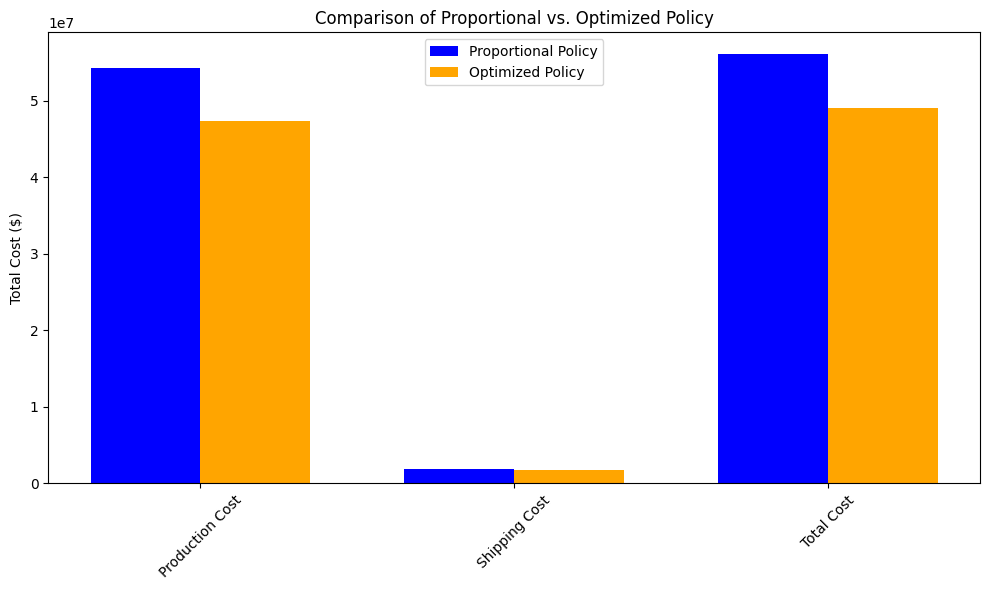

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # Bar width
x_indices = np.arange(len(x))  # X-axis positions

# Plot the bars
bar1 = ax.bar(x_indices - width / 2, proportional_values, width, label='Proportional Policy', color='blue')
bar2 = ax.bar(x_indices + width / 2, optimized_values, width, label='Optimized Policy', color='orange')

# Add titles and labels
ax.set_ylabel('Total Cost ($)')
ax.set_title('Comparison of Proportional vs. Optimized Policy')
ax.set_xticks(x_indices)
ax.set_xticklabels(x, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

## Capacity Expansion Analysis

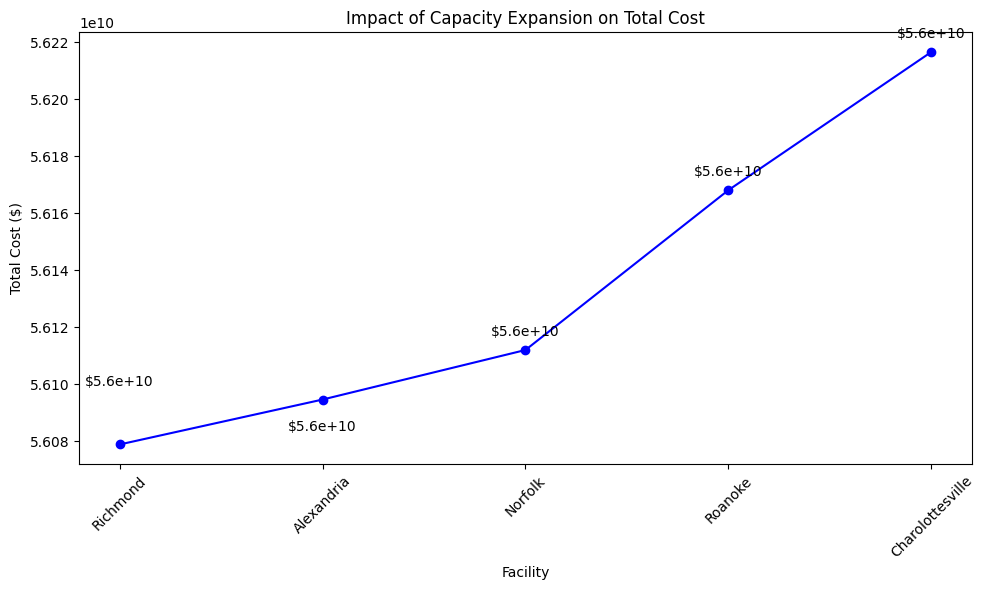

In [39]:
# Line chart for capacity expansion
plt.figure(figsize=(10, 6))
plt.plot(capacity_expansion_df['Facility'], capacity_expansion_df['Total Cost'], marker='o', color='blue')
plt.title('Impact of Capacity Expansion on Total Cost')
plt.ylabel('Total Cost ($)')
plt.xlabel('Facility')
for i, cost in enumerate(capacity_expansion_df['Total Cost']):
    plt.annotate(f"${cost:.1e}", (capacity_expansion_df['Facility'][i], cost), textcoords="offset points", xytext=(0, 10), ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Demand Increase Analysis

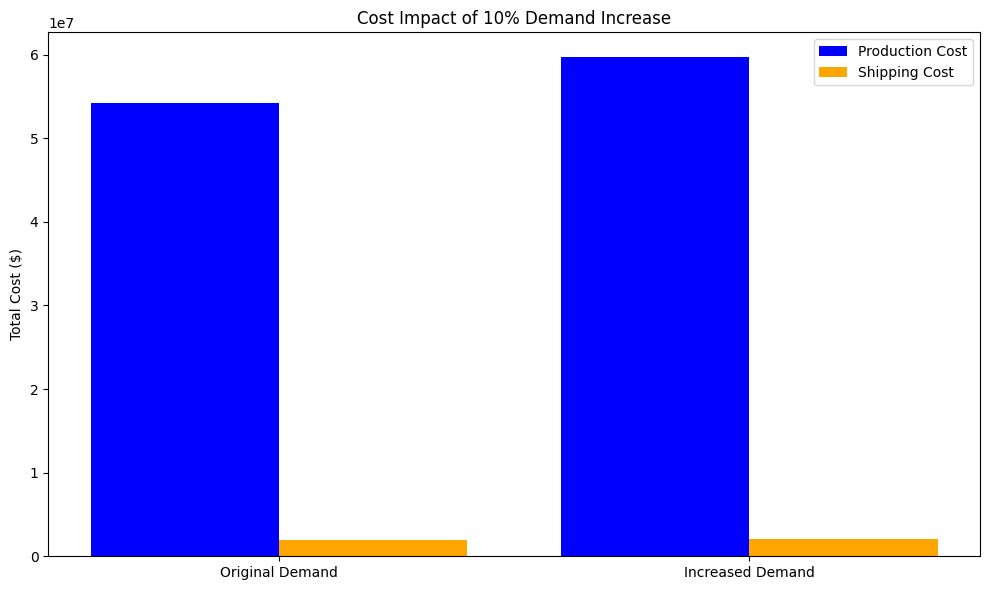

In [49]:
# Side-by-Side Bar Chart for Demand Increase Analysis
fig, ax = plt.subplots(figsize=(10, 6))

# Extract data
scenarios = ['Original Demand', 'Increased Demand']
production_costs = demand_comparison_df['Total Production Cost'].values
shipping_costs = demand_comparison_df['Total Shipping Cost'].values

# Create bar chart
x_indices = np.arange(len(scenarios))
width = 0.4

bar1 = ax.bar(x_indices - width / 2, production_costs, width, label='Production Cost', color='blue')
bar2 = ax.bar(x_indices + width / 2, shipping_costs, width, label='Shipping Cost', color='orange')

# Add labels, title, and legend
ax.set_ylabel('Total Cost ($)')
ax.set_title('Cost Impact of 10% Demand Increase')
ax.set_xticks(x_indices)
ax.set_xticklabels(scenarios)
ax.legend()
plt.tight_layout()
plt.show()

## Technology Adoption Analysis

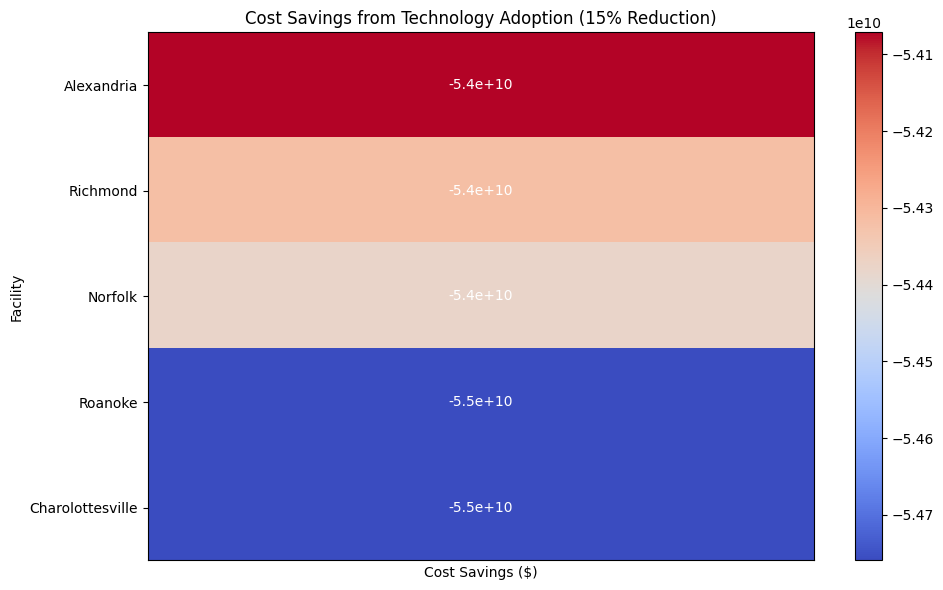

In [47]:
plt.figure(figsize=(10, 6))

cost_savings = tech_adoption_df['Cost Savings'].values.reshape(-1, 1)
facilities = tech_adoption_df['Facility'].values

plt.imshow(cost_savings, cmap='coolwarm', aspect='auto')


for i in range(len(facilities)):
    text = f"{cost_savings[i][0]:.1e}"  # Access the single value in each row
    plt.text(0, i, text, ha="center", va="center", color="white")

plt.yticks(ticks=np.arange(len(facilities)), labels=facilities)

plt.xticks([])

plt.colorbar()
plt.title('Cost Savings from Technology Adoption (15% Reduction)')
plt.ylabel('Facility')
plt.xlabel('Cost Savings ($)')
plt.tight_layout()

plt.show()
